# 📊 Phase 1: Dataset Exploration

**Objective:** Understand dataset composition to inform all subsequent analysis

**Key Deliverables:**
- CVE and CWE distribution
- Code sample characteristics
- Missing data analysis
- Nesting, line count, and comment/code ratio
- Sample selection for testing

---


In [1]:
# Setup and imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set up paths
project_root = Path('../')
data_dir = project_root / 'data'
raw_dir = data_dir / 'raw'
results_dir = project_root / 'results'

# Create results directory if it doesn't exist
results_dir.mkdir(exist_ok=True)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup complete!")
print(f"Project root: {project_root.resolve()}")
print(f"Raw data directory: {raw_dir}")
print(f"Results directory: {results_dir}")


Setup complete!
Project root: /Users/vernetemmanueladjobi/Desktop/KB_/vulnerability-kb
Raw data directory: ../data/raw
Results directory: ../results


## 1.1 Dataset Overview

First, let's understand what we're working with - the basic structure and content of our VulRAG Knowledge Base.


In [2]:
# Check VulRAG KB availability
print("Checking VulRAG Knowledge Base availability...")

if raw_dir.exists():
    kb_files = list(raw_dir.glob("*.json"))
    print(f"Found {len(kb_files)} KB files:")
    for file in sorted(kb_files):
        file_size = file.stat().st_size / 1024  # KB
        print(f"  {file.name} ({file_size:.1f} KB)")
else:
    print("ERROR: VulRAG KB directory not found")
    print("Please run: ./download_data.sh")
    raise FileNotFoundError("VulRAG KB not available")

print(f"\nReady to analyze {len(kb_files)} CWE knowledge bases")


Checking VulRAG Knowledge Base availability...
Found 10 KB files:
  gpt-4o-mini_CWE-119_316.json (1696.7 KB)
  gpt-4o-mini_CWE-125_316.json (1503.3 KB)
  gpt-4o-mini_CWE-200_316.json (1312.1 KB)
  gpt-4o-mini_CWE-20_316.json (1759.1 KB)
  gpt-4o-mini_CWE-264_316.json (1094.5 KB)
  gpt-4o-mini_CWE-362_316.json (3007.8 KB)
  gpt-4o-mini_CWE-401_316.json (831.1 KB)
  gpt-4o-mini_CWE-416_316.json (5882.9 KB)
  gpt-4o-mini_CWE-476_316.json (2621.1 KB)
  gpt-4o-mini_CWE-787_316.json (2035.0 KB)

Ready to analyze 10 CWE knowledge bases


In [3]:
def load_vulrag_kb():
    """Load all KB files and analyze structure"""
    print("="*60)
    print(" KNOWLEDGE BASE ANALYSIS")
    print("="*60)
    
    kb_data = {}
    total_cves = 0
    total_instances = 0
    global_cve_data = {}
    
    for kb_file in sorted(raw_dir.glob("*.json")):
        # Extract CWE from filename: gpt-4o-mini_CWE-119_316.json
        cwe = kb_file.stem.split('_')[1]  # CWE-119
        
        try:
            with open(kb_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            cwe_cve_count = 0
            cwe_instance_count = 0
            cwe_cve_data = {}
            
            # Iterate over all CVEs in this CWE file
            for cve_id, instances in data.items():
                instances_count = len(instances)
                
                # Update counters
                total_cves += 1
                cwe_cve_count += 1
                total_instances += instances_count
                cwe_instance_count += instances_count
                
                # Store CVE information
                cve_info = {
                    'cwe': cwe,
                    'instances_count': instances_count,
                    'file': kb_file.name
                }
                
                global_cve_data[cve_id] = cve_info
                cwe_cve_data[cve_id] = instances_count
            
            # Store data by CWE
            kb_data[cwe] = {
                'file': kb_file.name,
                'cve_count': cwe_cve_count,
                'instance_count': cwe_instance_count,
                'cve_list': cwe_cve_data
            }
            
        except Exception as e:
            print(f"ERROR loading {kb_file.name}: {e}")
            continue
    
    # Add global statistics
    kb_data['_summary'] = {
        'total_cves': total_cves,
        'total_instances': total_instances,
        'total_cwe_categories': len(kb_data) - 1,  # -1 to exclude _summary
        'all_cve_data': global_cve_data
    }
    
    return kb_data

# Load the knowledge base
vulrag_data = load_vulrag_kb()


 KNOWLEDGE BASE ANALYSIS


In [4]:
def display_analysis(kb_data):
    """Display formatted analysis"""
    summary = kb_data.get('_summary', {})
    
    print(f"GLOBAL SUMMARY:")
    print(f"   • {summary.get('total_cwe_categories', 0)} CWE categories")
    print(f"   • {summary.get('total_cves', 0)} unique CVEs")
    print(f"   • {summary.get('total_instances', 0)} function instances")
    
    print("\n" + "="*60)
    print("DETAIL BY CWE CATEGORY")
    print("="*60)
    
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):  # Skip metadata
            continue
            
        print(f"\n{cwe} has {info['cve_count']} CVEs (file: {info['file']})")
        print(f"   Total instances: {info['instance_count']}")
        print(f"   Average: {info['instance_count']/info['cve_count']:.1f} instances/CVE")
        print("   CVE list:")
        
        # Sort CVEs by number of instances (descending)
        sorted_cves = sorted(info['cve_list'].items(), key=lambda x: x[1], reverse=True)
        
        for cve_id, instances_count in sorted_cves[:5]:  # Show top 5 only
            if instances_count > 3:
                indicator = "[HIGH]"
            elif instances_count > 1:
                indicator = "[MED]"
            else:
                indicator = "[LOW]"
            print(f"      {indicator} {cve_id}: {instances_count} instance{'s' if instances_count > 1 else ''}")
        
        if len(sorted_cves) > 5:
            print(f"      ... and {len(sorted_cves) - 5} more CVEs")

# Display the analysis
display_analysis(vulrag_data)


GLOBAL SUMMARY:
   • 9 CWE categories
   • 1217 unique CVEs
   • 2317 function instances

DETAIL BY CWE CATEGORY

CWE-119 has 111 CVEs (file: gpt-4o-mini_CWE-119_316.json)
   Total instances: 173
   Average: 1.6 instances/CVE
   CVE list:
      [HIGH] CVE-2016-3134: 8 instances
      [HIGH] CVE-2013-1772: 7 instances
      [HIGH] CVE-2014-3184: 5 instances
      [HIGH] CVE-2017-18222: 4 instances
      [HIGH] CVE-2014-0205: 4 instances
      ... and 106 more CVEs

CWE-125 has 89 CVEs (file: gpt-4o-mini_CWE-125_316.json)
   Total instances: 140
   Average: 1.6 instances/CVE
   CVE list:
      [HIGH] CVE-2022-48502: 7 instances
      [HIGH] CVE-2017-17741: 5 instances
      [HIGH] CVE-2022-20132: 4 instances
      [MED] CVE-2014-7825: 3 instances
      [MED] CVE-2017-9074: 3 instances
      ... and 84 more CVEs

CWE-200 has 92 CVEs (file: gpt-4o-mini_CWE-200_316.json)
   Total instances: 153
   Average: 1.7 instances/CVE
   CVE list:
      [HIGH] CVE-2018-3665: 17 instances
      [HIGH] 

In [5]:
# Generate and save summary report
def generate_summary_report(kb_data, output_file):
    """Generate a summary report"""
    summary = kb_data.get('_summary', {})
    
    # Create a summary report 
    report = {
        "analysis_metadata": {
            "total_cwe_categories": summary.get('total_cwe_categories'),
            "total_cves": summary.get('total_cves'),
            "total_instances": summary.get('total_instances')
        },
        "cwe_breakdown": {},
        "top_cves_by_instances": {},
        "statistics": {}
    }
    
    # Breakdown by CWE
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
        report["cwe_breakdown"][cwe] = {
            "cve_count": info['cve_count'],
            "instance_count": info['instance_count'],
            "avg_instances_per_cve": round(info['instance_count']/info['cve_count'], 2),
            "file": info['file']
        }
    
    # Top CVEs by number of instances
    all_cves = summary.get('all_cve_data', {})
    top_cves = sorted(all_cves.items(), key=lambda x: x[1]['instances_count'], reverse=True)[:10]
    report["top_cves_by_instances"] = {
        cve: {"instances": data['instances_count'], "cwe": data['cwe']} 
        for cve, data in top_cves
    }
    
    # Statistics
    instance_counts = [data['instances_count'] for data in all_cves.values()]
    if instance_counts:
        report["statistics"] = {
            "avg_instances_per_cve": round(sum(instance_counts)/len(instance_counts), 2),
            "min_instances": min(instance_counts),
            "max_instances": max(instance_counts),
            "cves_with_multiple_instances": len([x for x in instance_counts if x > 1])
        }
    
    # Save
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        print(f"Summary report saved to: {output_file}")
        return report
    except Exception as e:
        print(f"Error while saving the report: {e}")
        return None

summary_report = generate_summary_report(vulrag_data, results_dir/"vulrag_summary_report.json")
print("\nDataset overview analysis completed!")


Summary report saved to: ../results/vulrag_summary_report.json

Dataset overview analysis completed!


## 1.2 Code Characteristics Analysis

Now let's analyze the code samples themselves to understand:
- Line count distribution → *inform timeout calculations*
- Function count per sample → *validate processing limits*  
- Nesting depth analysis → *justify AST_MAX_DEPTH*
- Comment/code ratio → *understand parsing complexity*


In [6]:
def analyze_code_sample(code_text):
    """Analyze a single code sample for characteristics"""
    if not code_text or not isinstance(code_text, str):
        return {
            'lines': 0,
            'chars': 0,
            'tokens': 0,
            'comments': 0,
            'functions': 0,
            'max_nesting': 0,
            'comment_ratio': 0.0
        }
    
    lines = code_text.split('\n')
    line_count = len(lines)
    char_count = len(code_text)
    
    # Count tokens (rough estimate)
    tokens = len(re.findall(r'\b\w+\b', code_text))
    
    # Count comments (// and /* */ style)
    comment_lines = 0
    for line in lines:
        stripped = line.strip()
        if stripped.startswith('//') or stripped.startswith('/*') or stripped.startswith('*'):
            comment_lines += 1
    
    # Count functions (basic pattern matching)
    function_patterns = [
        r'\b\w+\s+\w+\s*\([^)]*\)\s*{',  # return_type function_name(args) {
        r'\b(static|extern|inline)?\s*\w+\s+\w+\s*\([^)]*\)\s*{',  # with modifiers
    ]
    
    function_count = 0
    for pattern in function_patterns:
        function_count += len(re.findall(pattern, code_text, re.MULTILINE))
    
    # Estimate nesting depth
    max_nesting = 0
    current_nesting = 0
    
    for char in code_text:
        if char == '{':
            current_nesting += 1
            max_nesting = max(max_nesting, current_nesting)
        elif char == '}':
            current_nesting = max(0, current_nesting - 1)
    
    # Comment ratio
    comment_ratio = comment_lines / line_count if line_count > 0 else 0.0
    
    return {
        'lines': line_count,
        'chars': char_count,
        'tokens': tokens,
        'comments': comment_lines,
        'functions': function_count,
        'max_nesting': max_nesting,
        'comment_ratio': comment_ratio
    }

print("Code analysis functions defined.")


Code analysis functions defined.


In [7]:
# Analyze ALL code characteristics (comprehensive analysis)
def analyze_sample_code_characteristics(vulrag_data, sample_limit=None):
    """
    Analyze code characteristics from vulnerability samples
    Args:
        vulrag_data: Loaded VulRAG data
        sample_limit: Number of samples to analyze (None = all samples)
    """
    if sample_limit is None:
        print("Analyzing code characteristics from ALL samples...")
    else:
        print(f"Analyzing code characteristics from {sample_limit} samples...")
    
    processed_samples = 0
    all_characteristics = []
    missing_data_stats = defaultdict(int)
    
    for cwe, info in vulrag_data.items():
        if cwe.startswith('_'):
            continue
       
        print(f"Processing {cwe}...")
        cwe_file_path = raw_dir / info['file']
        
        try:
            with open(cwe_file_path, 'r', encoding='utf-8') as f:
                cwe_data = json.load(f)
        except Exception as e:
            print(f"Error loading {info['file']}: {e}")
            continue
        
        for cve_id, instances in cwe_data.items():
            for instance_idx, instance in enumerate(instances):
                # Check if we've reached the sample limit
                if sample_limit is not None and processed_samples >= sample_limit:
                    break
                    
                # Extract code samples
                code_before = instance.get('code_before_change', '')
                code_after = instance.get('code_after_change', '')
                
                # Track missing data
                if not code_before:
                    missing_data_stats['code_before_change'] += 1
                if not code_after:
                    missing_data_stats['code_after_change'] += 1
                
                # Analyze code_before_change if present
                if code_before:
                    chars_before = analyze_code_sample(code_before)
                    chars_before.update({
                        'cwe': cwe,
                        'cve_id': cve_id,
                        'instance_idx': instance_idx,
                        'code_type': 'before_change'
                    })
                    all_characteristics.append(chars_before)
                
                processed_samples += 1
                
            # Check if we've reached the sample limit
            if sample_limit is not None and processed_samples >= sample_limit:
                break
        
        # Check if we've reached the sample limit
        if sample_limit is not None and processed_samples >= sample_limit:
            break
    
    print(f"\nAnalyzed {len(all_characteristics)} code samples")
    print(f"Missing data summary:")
    for field, count in missing_data_stats.items():
        percentage = (count / processed_samples) * 100 if processed_samples > 0 else 0
        print(f"   {field}: {count} missing ({percentage:.1f}%)")
    
    return all_characteristics, missing_data_stats

# Run the analysis on ALL samples
code_characteristics, missing_data = analyze_sample_code_characteristics(vulrag_data, sample_limit=None)

Analyzing code characteristics from ALL samples...
Processing CWE-119...
Processing CWE-125...
Processing CWE-200...
Processing CWE-20...
Processing CWE-264...
Processing CWE-362...
Processing CWE-401...
Processing CWE-416...
Processing CWE-476...
Processing CWE-787...

Analyzed 2317 code samples
Missing data summary:


CODE CHARACTERISTICS SUMMARY
Total code samples analyzed: 2317

Basic statistics:
             lines         chars       tokens    functions  max_nesting  \
count  2317.000000   2317.000000  2317.000000  2317.000000  2317.000000   
mean     68.497626   1788.855848   197.830384     2.036254     2.392318   
std      93.487365   2560.683063   272.315221     1.424701     1.151027   
min       2.000000     39.000000     5.000000     0.000000     1.000000   
25%      22.000000    525.000000    58.000000     2.000000     2.000000   
50%      42.000000   1049.000000   118.000000     2.000000     2.000000   
75%      81.000000   2102.000000   232.000000     2.000000     3.000000   
max    1479.000000  34947.000000  4120.000000    22.000000     7.000000   

       comment_ratio  
count    2317.000000  
mean        0.067408  
std         0.093828  
min         0.000000  
25%         0.000000  
50%         0.028465  
75%         0.105882  
max         0.602339  

🎯 KEY INSIGHTS FOR TIMEOUT CALCULA

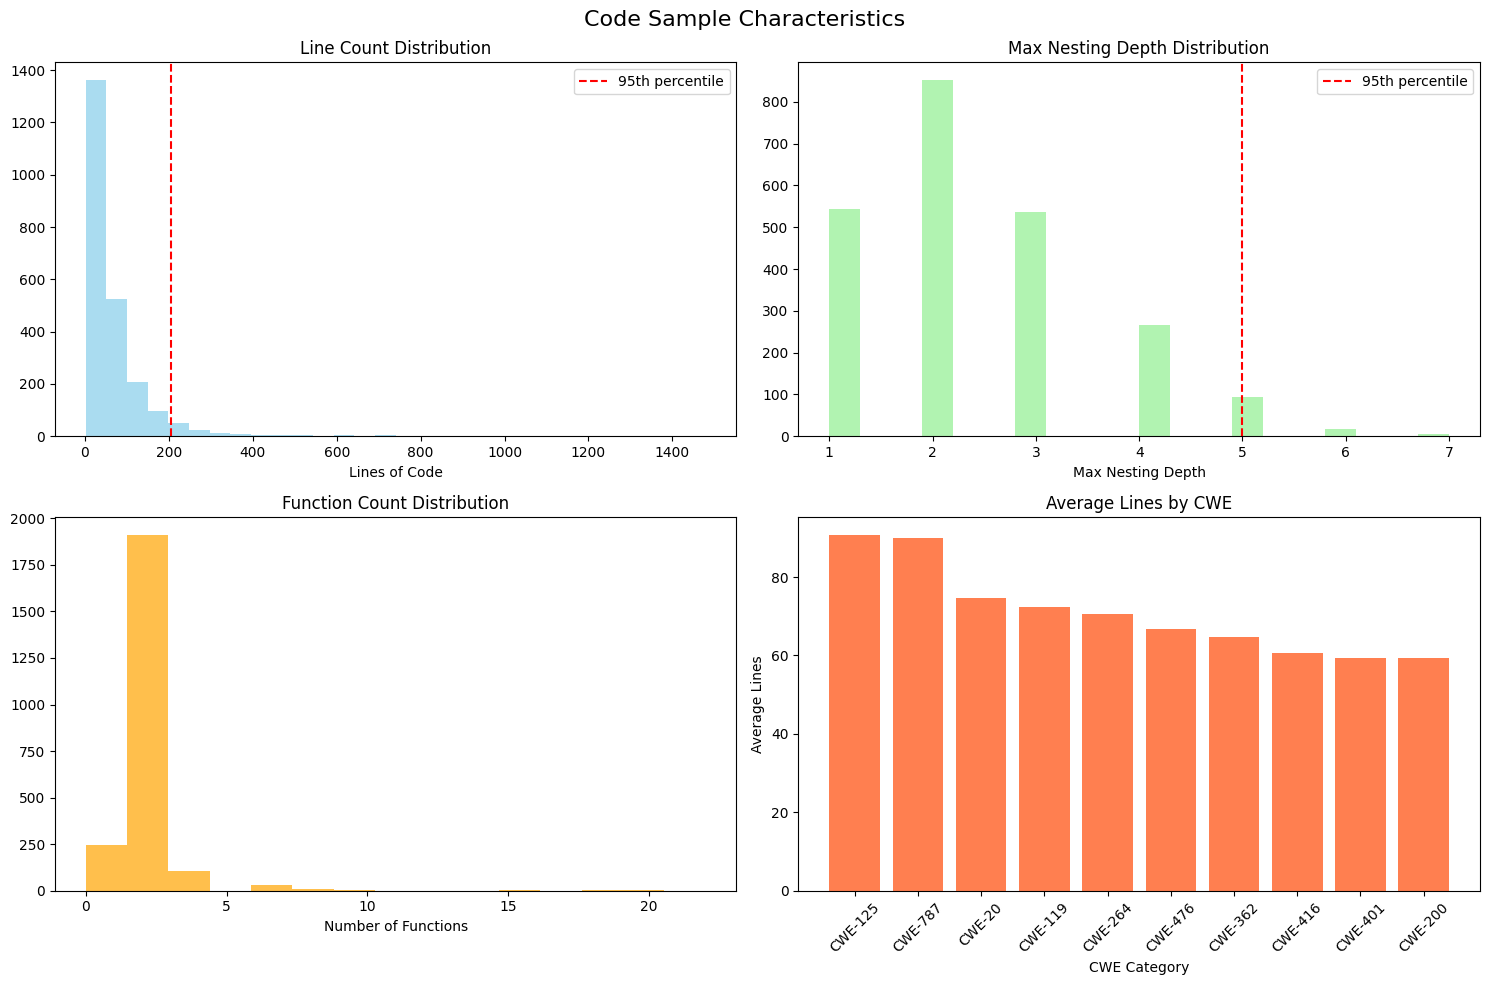


Code characteristics saved to: ../results/code_characteristics_sample.csv


In [8]:
# Analyze results and create visualizations
if code_characteristics:
    code_df = pd.DataFrame(code_characteristics)
    
    print("="*60)
    print("CODE CHARACTERISTICS SUMMARY")
    print("="*60)
    
    print(f"Total code samples analyzed: {len(code_df)}")
    print(f"\nBasic statistics:")
    stats_cols = ['lines', 'chars', 'tokens', 'functions', 'max_nesting', 'comment_ratio']
    print(code_df[stats_cols].describe())
    
    # Key insights
    print(f"\n🎯 KEY INSIGHTS FOR TIMEOUT CALCULATIONS:")
    lines_95 = code_df['lines'].quantile(0.95)
    nesting_95 = code_df['max_nesting'].quantile(0.95)
    print(f"   • 95th percentile lines: {lines_95:.0f}")
    print(f"   • 95th percentile nesting: {nesting_95:.0f}")
    print(f"   • Max lines observed: {code_df['lines'].max():.0f}")
    print(f"   • Max nesting observed: {code_df['max_nesting'].max():.0f}")
    print(f"   • Suggested timeout base: {max(10, lines_95/10):.0f} seconds")
    print(f"   • Suggested AST depth limit: {max(20, nesting_95+5):.0f}")
    
    # Create basic visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Code Sample Characteristics', fontsize=16)
    
    # Line count distribution
    axes[0,0].hist(code_df['lines'], bins=30, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Line Count Distribution')
    axes[0,0].set_xlabel('Lines of Code')
    axes[0,0].axvline(lines_95, color='red', linestyle='--', label='95th percentile')
    axes[0,0].legend()
    
    # Nesting depth distribution
    axes[0,1].hist(code_df['max_nesting'], bins=20, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Max Nesting Depth Distribution')
    axes[0,1].set_xlabel('Max Nesting Depth')
    axes[0,1].axvline(nesting_95, color='red', linestyle='--', label='95th percentile')
    axes[0,1].legend()
    
    # Function count distribution
    axes[1,0].hist(code_df['functions'], bins=15, alpha=0.7, color='orange')
    axes[1,0].set_title('Function Count Distribution')
    axes[1,0].set_xlabel('Number of Functions')
    
    # CWE comparison
    cwe_stats = code_df.groupby('cwe')['lines'].agg(['count', 'mean']).sort_values('mean', ascending=False)
    axes[1,1].bar(range(len(cwe_stats)), cwe_stats['mean'], color='coral')
    axes[1,1].set_title('Average Lines by CWE')
    axes[1,1].set_xlabel('CWE Category')
    axes[1,1].set_ylabel('Average Lines')
    axes[1,1].set_xticks(range(len(cwe_stats)))
    axes[1,1].set_xticklabels(cwe_stats.index, rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    code_df.to_csv(results_dir / 'code_characteristics_sample.csv', index=False)
    print(f"\nCode characteristics saved to: {results_dir / 'code_characteristics_sample.csv'}")
    
else:
    print("No code characteristics data to analyze.")


## 📋 Phase 1 Summary and Next Steps

Based on this initial exploration, we now have empirical understanding of our dataset:


In [9]:
# Final Phase 1 Validation and Summary
print("="*80)
print("🎯 PHASE 1: DATASET EXPLORATION - COMPLETION SUMMARY")
print("="*80)

# Validate deliverables
summary = vulrag_data.get('_summary', {})

print("\n✅ 1.1 DATASET OVERVIEW COMPLETED:")
print(f"   • {summary.get('total_cwe_categories', 0)} CWE categories analyzed")
print(f"   • {summary.get('total_cves', 0)} unique CVEs identified") 
print(f"   • {summary.get('total_instances', 0)} function instances processed")

if code_characteristics:
    print("\n✅ 1.2 CODE CHARACTERISTICS COMPLETED:")
    print(f"   • {len(code_characteristics)} code samples analyzed")
    print(f"   • Processing complexity baselines established")
    print(f"   • Timeout recommendations derived")

print("\n📁 GENERATED FILES:")
output_files = [
    'vulrag_summary_report.json',
    'code_characteristics_sample.csv'
]

for file in output_files:
    file_path = results_dir / file
    if file_path.exists():
        size = file_path.stat().st_size / 1024
        print(f"   ✅ {file} ({size:.1f} KB)")
    else:
        print(f"   ❌ {file} (MISSING)")

# Key insights for next phase
if code_characteristics:
    code_df = pd.DataFrame(code_characteristics)
    lines_95 = code_df['lines'].quantile(0.95)
    nesting_95 = code_df['max_nesting'].quantile(0.95)
    
    print(f"\n🎯 KEY INSIGHTS FOR PHASE 2 (Performance Analysis):")
    print(f"   • 95th percentile processing target: {lines_95:.0f} lines")
    print(f"   • Suggested base timeout: {max(10, lines_95/10):.0f} seconds")
    print(f"   • AST depth limit recommendation: {max(20, nesting_95+5):.0f}")
    print(f"   • {len(code_df)} samples available for performance testing")

# Next steps
print(f"\n🚀 NEXT STEPS:")
print(f"   1. Review and validate these findings")
print(f"   2. Confirm understanding of dataset complexity")
print(f"   3. Proceed to Phase 2: Processing Performance Analysis")
print(f"   4. Use these insights to measure realistic processing times")

print(f"\n🏁 PHASE 1 COMPLETE - READY FOR PHASE 2!")
print(f"   Dataset characteristics: UNDERSTOOD ✅")
print(f"   Processing baselines: ESTABLISHED ✅") 
print(f"   Performance targets: IDENTIFIED ✅")


🎯 PHASE 1: DATASET EXPLORATION - COMPLETION SUMMARY

✅ 1.1 DATASET OVERVIEW COMPLETED:
   • 9 CWE categories analyzed
   • 1217 unique CVEs identified
   • 2317 function instances processed

✅ 1.2 CODE CHARACTERISTICS COMPLETED:
   • 2317 code samples analyzed
   • Processing complexity baselines established
   • Timeout recommendations derived

📁 GENERATED FILES:
   ✅ vulrag_summary_report.json (2.6 KB)
   ✅ code_characteristics_sample.csv (154.5 KB)

🎯 KEY INSIGHTS FOR PHASE 2 (Performance Analysis):
   • 95th percentile processing target: 205 lines
   • Suggested base timeout: 20 seconds
   • AST depth limit recommendation: 20
   • 2317 samples available for performance testing

🚀 NEXT STEPS:
   1. Review and validate these findings
   2. Confirm understanding of dataset complexity
   3. Proceed to Phase 2: Processing Performance Analysis
   4. Use these insights to measure realistic processing times

🏁 PHASE 1 COMPLETE - READY FOR PHASE 2!
   Dataset characteristics: UNDERSTOOD ✅
 